We have a good working version; lets try and make a few final adjustments:

In [1]:
import jax.numpy as jnp
import jax
import numpy as np

import matplotlib.pyplot as plt
from functools import partial

from time import time
%config InlineBackend.figure_format = 'svg'

In [2]:
# getting baseline data
data = jnp.load("u_train.npy")

In [3]:
def erf_kernel(uv, uu, vv):
    z = 2 * uv / jnp.sqrt((1 + 2 * uu)*(1 + 2 * vv)) # on diagonal uu = uv = vu
    return 2 / jnp.pi * jnp.arcsin(z)

def diagonal_update_fn(sigma_i, sigma_r, sigma_b, kernel):
    def update_fn(k_prev, gram_idx):
        uv = sigma_i ** 2 * gram_idx + sigma_r **2 * k_prev + sigma_b**2
        k = kernel(uv, uv, uv)
        return k, k
    return update_fn

def off_diagonal_update_fn(sigma_i, sigma_r, sigma_b, kernel, gram, k_diagonal, offset):
    def update_fn(k_prev, idx):
        uv = sigma_i ** 2 * gram[offset + idx, idx] + sigma_r **2 * k_prev + sigma_b**2
        uu, vv = u_dot_u[idx], u_dot_u[idx + offset]
        k = kernel(uv, uu, vv)
        return k, k
    u_dot_u = sigma_i**2 * jnp.diag(gram) + sigma_r**2 * k_diagonal + sigma_b**2
    return update_fn

def recurrent_kernel(kernel_fn, sigma_i, sigma_r, sigma_b, data):
    # Precalculating gram
    gram = jnp.dot(data, data.T)
    n_samples = gram.shape[0]

    # Getting diagonal results
    k_diagonal = jax.lax.scan(diagonal_update_fn(sigma_i, sigma_r, sigma_b, kernel_fn), 0.0, jnp.diag(gram))[1]

    # Getting off diagonal elements
    diagonal_op = lambda offset: jax.lax.scan(off_diagonal_update_fn(sigma_i, sigma_r, sigma_b, erf_kernel, gram, k_diagonal, offset), 0.0, jnp.arange(n_samples))
    K_recurrent = jax.vmap(diagonal_op)(jnp.arange(1, n_samples))[1]  #start at 1 cause diagonal

    # Postprocessing into proper K
    K_recurrent = jnp.concatenate((k_diagonal[None, :], K_recurrent), axis=0) # adding diagonal
    K_recurrent = jax.vmap(lambda i: jnp.roll(K_recurrent[:, i], shift=i), out_axes=1)(jnp.arange(n_samples)) # rolling to put elements on diagonal
    K_recurrent = jnp.tril(K_recurrent) + jnp.tril(K_recurrent).T # extracting lower triangular and adding to upper
    K_recurrent = jax.ops.index_update(K_recurrent, jnp.diag_indices(n_samples), k_diagonal) # setting diagonal correctly
    return K_recurrent

In [4]:
sigma_i = 0.4
sigma_r = 0.9
sigma_b = 0.1

In [5]:
K_baseline = recurrent_kernel(erf_kernel, sigma_i, sigma_r, sigma_b, data)

(0.0, 1000.0)

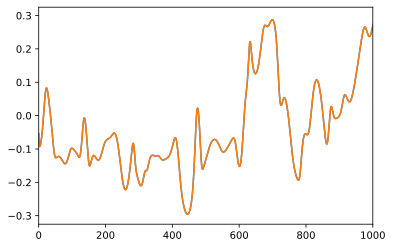

In [6]:
offset = 5000
plt.plot(jnp.diag(K_baseline, k=offset))
plt.plot(jnp.diag(K_baseline, k=-offset))

plt.xlim([0, 1000])

Good - its perfectly symmetrical (also makes sense given that we do it manyually)

In [13]:
K_train = recurrent_kernel(erf_kernel, sigma_i, sigma_r, sigma_b, data)
K_train += 1.1 * jnp.dot(data, data.T)  # Adding gram matrix 

ini = 1000 # we remove the first 1000 warmup time
K_train = K_train[ini:, ini:]

# L2
alpha = 1e-2
K_train = jax.ops.index_add(K_train, jnp.diag_indices(K_train.shape[0]), alpha)
c, low = jax.scipy.linalg.cho_factor(K_train, check_finite=False)
W_out = jax.scipy.linalg.cho_solve((c, low), data[ini:], check_finite=False)

In [22]:
W_out

DeviceArray([[ 0.00144616,  0.00485791,  0.0070205 , ..., -0.00588871,
              -0.0047266 , -0.00210863],
             [ 0.0003809 ,  0.00380202,  0.00625592, ..., -0.00592572,
              -0.00516244, -0.00292755],
             [-0.00059588,  0.00273443,  0.00538341, ..., -0.00582521,
              -0.00543343, -0.0036027 ],
             ...,
             [-0.00511759, -0.00357025, -0.00054916, ..., -0.00314824,
              -0.00449838, -0.00531862],
             [-0.00525838, -0.00364738, -0.00044179, ..., -0.00294313,
              -0.00445578, -0.0054392 ],
             [-0.00531358, -0.00362115, -0.00022936, ..., -0.00285089,
              -0.00444767, -0.00551495]], dtype=float32)

In [15]:
K_train = recurrent_kernel(erf_kernel, sigma_i, sigma_r, sigma_b, data)
K_train += 1.1 * jnp.dot(data, data.T)  # Adding gram matrix 
K_train = K_train[:, ini:]

train_prediction = jnp.dot(K_train, W_out)

In [16]:
train_prediction.shape

(10000, 100)

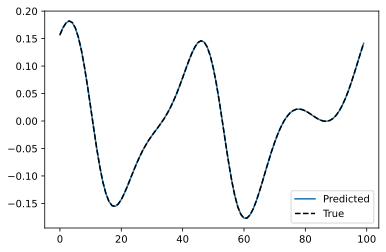

In [33]:
frame = 1000
plt.plot(train_prediction[frame], label='Predicted')
plt.plot(data[frame], 'k--', label='True')
plt.legend()

In [24]:
baseline = jnp.load('K_baseline.npy')

In [28]:
K_train = recurrent_kernel(erf_kernel, sigma_i, sigma_r, sigma_b, data)

In [31]:
jnp.mean(jnp.abs(baseline - K_train))

DeviceArray(0.00689069, dtype=float32)

In [32]:
jnp.max(jnp.abs(baseline - K_train))

DeviceArray(0.03331821, dtype=float32)

(0.0, 2000.0)

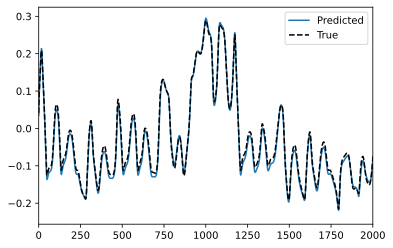

In [36]:
frame = 1000
plt.plot(K_train[frame], label='Predicted')
plt.plot(baseline[frame], 'k--', label='True')
plt.legend()
plt.xlim([0, 2000])

In [23]:
jnp.save("K_diagonal.npy", K_train)

Okay thats good.

In [7]:
f = jax.jit(recurrent_kernel, static_argnums=(0, ))
_ = f(erf_kernel, sigma_i, sigma_r, data) # compiling

In [8]:
%%timeit
f(erf_kernel, sigma_i, sigma_r, data).block_until_ready()

169 ms ± 66.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
def erf_kernel(uv, uu, vv):
    z = 2 * uv / jnp.sqrt((1 + 2 * uu)*(1 + 2 * vv)) # on diagonal uu = uv = vu
    return 2 / jnp.pi * jnp.arcsin(z)

def diagonal_update_fn(sigma_i, sigma_r, kernel):
    def update_fn(k_prev, gram_idx):
        uv = sigma_i ** 2 * gram_idx + sigma_r **2 * k_prev
        k = kernel(uv, uv, uv)
        return k, k
    return update_fn

def off_diagonal_update_fn(sigma_i, sigma_r, kernel):
    def update_fn(k_prev, x):
        gram, uu, vv = x
        uv = sigma_i ** 2 * gram + sigma_r **2 * k_prev
        k = kernel(uv, uu, vv)
        return k, k
    return update_fn

def recurrent_kernel(kernel_fn, sigma_i, sigma_r, data):
    # Precalculating gram
    n_samples = data.shape[0]
    gram_horizontal = jax.vmap(lambda i: jnp.roll(jnp.dot(data, data.T)[:, i], shift=-i), out_axes=1)(jnp.arange(n_samples)) # rolling to put diagonal elements on horizontal and pad
   
    # Getting diagonal results
    k_diagonal = jax.lax.scan(diagonal_update_fn(sigma_i, sigma_r, kernel_fn), 0.0, gram_horizontal[0, :])[1]

    # Getting off diagonal elements
    u_dot_u = sigma_i**2 * gram_horizontal[0, :] + sigma_r**2 * k_diagonal
    diagonal_op = lambda offset: jax.lax.scan(off_diagonal_update_fn(sigma_i, sigma_r, erf_kernel), 0.0, (gram_horizontal[offset, :], u_dot_u, jnp.roll(u_dot_u, -offset)))
    K_recurrent = jax.vmap(diagonal_op)(jnp.arange(1, n_samples))[1]  #start at 1 cause diagonal

    # Postprocessing into proper K
    K_recurrent = jnp.concatenate((k_diagonal[None, :], K_recurrent), axis=0) # adding diagonal
    K_recurrent = jax.vmap(lambda i: jnp.roll(K_recurrent[:, i], shift=i), out_axes=1)(jnp.arange(n_samples)) # rolling to put elements on diagonal
    K_recurrent = jnp.tril(K_recurrent) + jnp.tril(K_recurrent).T # extracting lower triangular and adding to upper
    K_recurrent = jax.ops.index_update(K_recurrent, jnp.diag_indices(n_samples), k_diagonal) # setting diagonal correctly
    return K_recurrent

In [17]:
f = jax.jit(recurrent_kernel, static_argnums=(0, ))
_ = f(erf_kernel, sigma_i, sigma_r, data) # compiling

In [18]:
%%timeit
f(erf_kernel, sigma_i, sigma_r, data).block_until_ready()

173 ms ± 86.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
def erf_kernel(uv, uu, vv):
    z = 2 * uv / jnp.sqrt((1 + 2 * uu)*(1 + 2 * vv)) # on diagonal uu = uv = vu
    return 2 / jnp.pi * jnp.arcsin(z)

def diagonal_update_fn(sigma_i, sigma_r, kernel):
    def update_fn(k_prev, gram):
        uv = sigma_i ** 2 * gram + sigma_r **2 * k_prev
        k = kernel(uv, uv, uv)
        return k, k
    return update_fn

def off_diagonal_update_fn(sigma_i, sigma_r, kernel):
    def update_fn(k_prev, x):
        gram, uu, vv = x
        uv = sigma_i ** 2 * gram + sigma_r **2 * k_prev
        k = kernel(uv, uu, vv)
        return k, k
    return update_fn

def recurrent_kernel(kernel_fn, sigma_i, sigma_r, data):
    # Precalculating gram
    n_samples = data.shape[0]
    gram_horizontal = diagonal_to_horizontal(jnp.dot(data, data.T)) # rolling to put diagonal elements on horizontal and pad
   
    # Getting diagonal results
    k_diagonal = jax.lax.scan(diagonal_update_fn(sigma_i, sigma_r, kernel_fn), 0.0, gram_horizontal[0, :])[1]

    # Getting off diagonal elements
    u_dot_u = sigma_i**2 * gram_horizontal[0] + sigma_r**2 * k_diagonal
    iterator = jax.vmap(lambda offset: jnp.stack([u_dot_u, jnp.roll(u_dot_u, -offset)], axis=1), out_axes=0)(jnp.arange(1, n_samples))
    iterator = jnp.concatenate([gram_horizontal[1:][:, :, None], iterator], axis=-1)
    K_recurrent = jax.vmap(lambda inputs: jax.lax.scan(off_diagonal_update_fn(sigma_i, sigma_r, kernel_fn), 0.0, inputs)[1])(iterator)

    # Postprocessing into proper K
    K_recurrent = jnp.concatenate((k_diagonal[None, :], K_recurrent), axis=0) # adding diagonal
    K_recurrent = horizontal_to_diagonal(K_recurrent) # rolling to put elements on diagonal
    K_recurrent = jnp.tril(K_recurrent) + jnp.tril(K_recurrent).T # extracting lower triangular and adding to upper
    K_recurrent = jax.ops.index_update(K_recurrent, jnp.diag_indices(n_samples), k_diagonal) # setting diagonal correctly
    return K_recurrent

def diagonal_to_horizontal(X):
    """Moves diagonal to horizontal."""
    return jax.vmap(lambda i: jnp.roll(X[:, i], shift=-i), out_axes=1)(jnp.arange(X.shape[1])) # rolling to put diagonal elements on horizontal and pad
    
def horizontal_to_diagonal(X):
    """Moves diagonal to horizontal."""
    return jax.vmap(lambda i: jnp.roll(X[:, i], shift=i), out_axes=1)(jnp.arange(X.shape[1])) # rolling to put diagonal elements on horizontal and pad

In [40]:
f = jax.jit(recurrent_kernel, static_argnums=(0, ))
_ = f(erf_kernel, sigma_i, sigma_r, data) # compiling

In [41]:
%%timeit
f(erf_kernel, sigma_i, sigma_r, data).block_until_ready()

175 ms ± 259 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [3]:
def erf_kernel(uv, uu, vv):
    z = 2 * uv / jnp.sqrt((1 + 2 * uu)*(1 + 2 * vv)) # on diagonal uu = uv = vu
    return 2 / jnp.pi * jnp.arcsin(z)

def diagonal_update_fn(sigma_i, sigma_r, kernel):
    def update_fn(k_prev, gram):
        uv = sigma_i ** 2 * gram + sigma_r **2 * k_prev
        k = kernel(uv, uv, uv)
        return k, k
    return update_fn

def off_diagonal_update_fn(sigma_i, sigma_r, kernel):
    def update_fn(k_prev, inputs):
        gram, uu, vv = inputs
        uv = sigma_i ** 2 * gram + sigma_r **2 * k_prev
        k = kernel(uv, uu, vv)
        return k, k
    return update_fn

def recurrent_kernel(kernel_fn, sigma_i, sigma_r, data):
    # Precalculating gram
    n_samples = data.shape[0]
    gram_horizontal = diagonal_to_horizontal(jnp.dot(data, data.T)) # rolling to put diagonal elements on horizontal 
   
    # Getting diagonal results
    k_diagonal = jax.lax.scan(diagonal_update_fn(sigma_i, sigma_r, kernel_fn), 0.0, gram_horizontal[0, :])[1]

    # Getting off diagonal elements
    uu = sigma_i**2 * gram_horizontal[0] + sigma_r**2 * k_diagonal
    vv = jax.vmap(lambda offset: jnp.roll(uu, -offset), out_axes=0)(jnp.arange(1, n_samples))
    K_recurrent = jax.vmap(lambda gram, vv: jax.lax.scan(off_diagonal_update_fn(sigma_i, sigma_r, kernel_fn), 0.0, (gram, uu, vv))[1])(gram_horizontal[1:], vv)

    # Postprocessing into proper K
    K_recurrent = jnp.concatenate((k_diagonal[None, :], K_recurrent), axis=0) # adding diagonal
    K_recurrent = horizontal_to_diagonal(K_recurrent) # rolling to put elements on diagonal
    K_recurrent = jnp.tril(K_recurrent) + jnp.tril(K_recurrent).T # extracting lower triangular and adding to upper
    K_recurrent = jax.ops.index_update(K_recurrent, jnp.diag_indices(n_samples), k_diagonal) # setting diagonal correctly
    return K_recurrent

def diagonal_to_horizontal(X):
    """Moves diagonal to horizontal."""
    return jax.vmap(lambda i: jnp.roll(X[:, i], shift=-i), out_axes=1)(jnp.arange(X.shape[1])) # rolling to put diagonal elements on horizontal and pad
    
def horizontal_to_diagonal(X):
    """Moves diagonal to horizontal."""
    return jax.vmap(lambda i: jnp.roll(X[:, i], shift=i), out_axes=1)(jnp.arange(X.shape[1])) # rolling to put diagonal elements on horizontal and pad

In [4]:
f = jax.jit(recurrent_kernel, static_argnums=(0, ))
_ = f(erf_kernel, sigma_i, sigma_r, data) # compiling

NameError: name 'sigma_i' is not defined

In [62]:
%%timeit
f(erf_kernel, sigma_i, sigma_r, data).block_until_ready()

162 ms ± 194 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [83]:
def gram(kernel_fn, sigma_i, sigma_r, data):
    # Precalculating gram
    n_samples = data.shape[0]
    gram_horizontal = diagonal_to_horizontal(jnp.dot(data, data.T)) # rolling to put diagonal elements on horizontal 
    return gram_horizontal

In [84]:
f = jax.jit(gram, static_argnums=(0, ))
_ = f(erf_kernel, sigma_i, sigma_r, data) # compiling

In [85]:
%%timeit 
f(erf_kernel, sigma_i, sigma_r, data).block_until_ready()

12.8 ms ± 46.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [86]:
def diag(kernel_fn, sigma_i, sigma_r, data):
    # Precalculating gram
    n_samples = data.shape[0]
    gram_horizontal = diagonal_to_horizontal(jnp.dot(data, data.T)) # rolling to put diagonal elements on horizontal 
   
    # Getting diagonal results
    k_diagonal = jax.lax.scan(diagonal_update_fn(sigma_i, sigma_r, kernel_fn), 0.0, gram_horizontal[0, :])[1]
    return k_diagonal

In [90]:
f = jax.jit(diag, static_argnums=(0, ))
_ = f(erf_kernel, sigma_i, sigma_r, data) # compiling

In [91]:
%%timeit 
f(erf_kernel, sigma_i, sigma_r, data).block_until_ready()

79.9 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [89]:
def nondiag(kernel_fn, sigma_i, sigma_r, data):
    # Precalculating gram
    n_samples = data.shape[0]
    gram_horizontal = diagonal_to_horizontal(jnp.dot(data, data.T)) # rolling to put diagonal elements on horizontal 
   
    # Getting diagonal results
    k_diagonal = jax.lax.scan(diagonal_update_fn(sigma_i, sigma_r, kernel_fn), 0.0, gram_horizontal[0, :])[1]

    # Getting off diagonal elements
    uu = sigma_i**2 * gram_horizontal[0] + sigma_r**2 * k_diagonal
    vv = jax.vmap(lambda offset: jnp.roll(uu, -offset), out_axes=0)(jnp.arange(1, n_samples))
    K_recurrent = jax.vmap(lambda gram, vv: jax.lax.scan(off_diagonal_update_fn(sigma_i, sigma_r, kernel_fn), 0.0, (gram, uu, vv))[1])(gram_horizontal[1:], vv)
    return K_recurrent

In [92]:
f = jax.jit(nondiag, static_argnums=(0, ))
_ = f(erf_kernel, sigma_i, sigma_r, data) # compiling

In [93]:
%%timeit 
f(erf_kernel, sigma_i, sigma_r, data).block_until_ready()

160 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
